# ENGIE QTEM Data Challenge – 2025  

This notebook is a comprehensive and reproducible workflow to solve the ENGIE QTEM Data Challenge. The challenge is focused on optimizing a renewable energy asset portfolio based on weather, production, and market pricing data.

### Key Business Questions:
- Which combination of renewable energy assets yields the highest production with the least variability?
- How do revenue considerations (market price data) affect the optimal portfolio selection?
- What are the differences between production-driven and revenue-driven optimization?
- How would the results change if real-world inefficiencies (e.g. curtailments) were removed?

---

### Final Deliverables:
- Reproducible optimization models (production & revenue)
- Portfolio performance metrics (mean output, standard deviation, volatility)
- Comparative analysis & sensitivity insights
- Final report and presentation-ready visualizations

---

### Data Overview:
- **Solar Production Sites:** 71 (Belgium, Germany, Netherlands)
- **Wind Sites:** 99 (onshore + offshore)
- **Weather Variables:** Temperature, wind speed/direction, cloud cover, solar radiation
- **Prices:** Quarter-hourly and hourly market prices (Day-Ahead, Intraday, ISP)
- **Metadata:** Site locations, variable definitions

---

## Available Data:

- **Solar Data Folder:** Contains files for each solar site:
  - Dew Point (`d2m`)
  - Total Cloud Cover (`tcc`)
  - Temperature (`t2m`)
  - Solar Radiation (`ssr`)
  - Wind Angle at 10m (`angle10`)
  - Wind Speed at 10m (`speed10`)
  - Load Factor (`factor`)

- **Wind Data Folder:** Contains files for each wind site:
  - Wind Angle at 100m (`angle100`)
  - Wind Speed at 100m (`speed100`)
  - Load Factor (`factor`)

- **Price and Liquidity Data:**
  - Day Ahead and Intraday prices.

- **Additional Files:**
  - Sites anonymized data (`sites_anonymized.csv`)
  - Data Dictionary (`data_dictionary.xlsx`)

In [19]:
import pandas as pd
import numpy as np
from geopy.extra.rate_limiter import RateLimiter
from geopy.geocoders import Nominatim
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from glob import glob
from tqdm import tqdm
import geopandas as gpd
from shapely.geometry import Point
import folium
from folium.plugins import MarkerCluster
import geodatasets
import contextily as ctx
import os

# 1. Comprehensive Data Assessment

In this section, we:
- Explore metadata to understand the site distribution
- Examine weather, production, and price data structure
- Identify missing values, timestamp irregularities, and data format issues
- Prepare for integration and cleaning

### 📊 Price & Liquidity Data Cleaning Summary

We started with a raw pricing dataset containing 59 columns and 132,310 timestamped records, covering multiple market types (Day-Ahead, Intraday, Imbalance) across Belgium (BE), Germany (DE), the Netherlands (NL), and France (FR).

#### ✅ Actions Taken:
- Removed all `volume` columns, which are not required in the ENGIE optimization objective (no use for liquidity or transaction volume).
- Dropped all columns related to France (`FR`) since the challenge scope is limited to BE, DE, and NL.
- Excluded rarely populated or redundant formats such as half-hour (HH) pricing and kept only **Hourly and Quarter-Hourly (QH)** series where reasonably populated.
- Retained all Day-Ahead (`DA_*`) pricing columns.
- Retained relevant Intraday pricing layers: `ID1`, `ID3`, and `IDFull`, for both `Hourly` and `QH` formats.
- Retained flat imbalance prices `ISP_*`, as well as `ISP_SHORT_NL` and `ISP_LONG_NL` for modeling imbalance market logic in Part 2 or Part 4.

#### 📦 Resulting Dataset:
- Final shape: **132,310 rows × 26 columns**
- Includes all pricing columns required for Parts **2, 3, and 4** of the challenge.
- Structured to support reproducible modeling and easy merging with production and weather data.

In [23]:
# Load metadata
sites_df = pd.read_csv("/Users/hossameldinelhendawy/Documents/QDC-Lib/sites_anonymized.csv")
price_df = pd.read_csv("/Users/hossameldinelhendawy/Documents/QDC-Lib/intraday_indices_prices_and_liquidity.csv")

# Datetime column modification
price_df.rename(columns={price_df.columns[0]: "datetime"}, inplace=True)
price_df['datetime'] = pd.to_datetime(price_df['datetime'])

/var/folders/5f/8x4b66f12jxblmgjlz1qymv80000gn/T/ipykernel_37479/3748134077.py:7: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  price_df['datetime'] = pd.to_datetime(price_df['datetime'])


In [ ]:
# 1. Load country shapefile
world = gpd.read_file("/Users/hossameldinelhendawy/Documents/QDC-Lib/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp")

# 2. Spatial join using 'NAME' for country assignment
sites_with_country = gpd.sjoin(
    sites_gdf,
    world[['NAME', 'geometry']],
    how='left',
    predicate='within'
).reset_index(drop=True)

# 3. Assign 'country' column cleanly
sites_with_country.drop(columns=[col for col in ['country'] if col in sites_with_country.columns], inplace=True)
sites_with_country.rename(columns={'NAME': 'country'}, inplace=True)

# 4. Manually assign missing offshore sites to Germany
sites_with_country.loc[
    (sites_with_country['country'].isna()) &
    (sites_with_country['type'] == 'Wind Offshore'),
    'country'
] = 'Germany'

# 5. Drop French sites
sites_with_country = sites_with_country[sites_with_country['country'] != 'France']

# 6. Drop unused spatial join columns
sites_df = sites_with_country.drop(columns=[col for col in ['geometry', 'index_right'] if col in sites_with_country.columns])

# 7. Format site ID
sites_df['site'] = sites_df['site'].astype(int)

130


In [ ]:
# Selection of relevant price columns for Parts 1–4
columns_to_keep = ['datetime']

# Add DA prices
for country in ['BE', 'DE', 'NL']:
    col = f'DA_{country}'
    if col in price_df.columns:
        columns_to_keep.append(col)

# Add hourly and QH intraday prices
intraday_types = ['ID1', 'ID3', 'IDFull']
resolutions = ['Hourly', 'QH']

for market in intraday_types:
    for resolution in resolutions:
        for country in ['BE', 'DE', 'NL']:
            col = f'{market}_{resolution}_{country}_price'
            if col in price_df.columns:
                columns_to_keep.append(col)

# Add Imbalance prices
for country in ['BE', 'DE', 'NL']:
    # Flat ISP
    col_flat = f'ISP_{country}'
    if col_flat in price_df.columns:
        columns_to_keep.append(col_flat)
    # NL-specific imbalance split
    col_short = f'ISP_SHORT_{country}'
    col_long = f'ISP_LONG_{country}'
    if col_short in price_df.columns:
        columns_to_keep.append(col_short)
    if col_long in price_df.columns:
        columns_to_keep.append(col_long)

# Apply filter
price_cleaned_df = price_df[columns_to_keep].copy()
print()

## ☀️ Solar Data Preprocessing Summary

We prepared the solar dataset for modeling by executing the following structured pipeline:

### 1. Site Discovery & Variable Definition
- Loaded all `.csv` files from the solar folder
- Extracted 71 unique site IDs
- Defined the target variables:  
  - Weather: `d2m`, `tcc`, `t2m`, `ssr`, `angle10`, `speed10`  
  - Production: `load_factor`

### 2. Per-Site Loading & Merging
- For each site, we loaded its 7 variable files
- Parsed and standardized the `datetime` column
- Merged all variables on `datetime`
- Added a `site_id` column
- Stored the result in `solar_site_data[site_id]`

### 3. Timeline Construction
- Extracted all timestamps across all sites
- Built a unified hourly index:
  - Start: `2018-12-31 23:00:00`
  - End: `2024-10-01 00:00:00`
  - Total timestamps: `50,402`
  - Frequency: **Hourly**

### 4. Site Reindexing
- Reindexed every site’s dataframe to the unified hourly timeline
- Preserved missing data as `NaN`
- Stored aligned sites in `solar_site_data_aligned`

### 5. Final Stacking
- Combined all aligned sites into a single dataframe `solar_all_df`
- Shape: `3,578,542 rows × 9 columns`
- Columns: `datetime`, 6 weather vars, `load_factor`, `site_id`
- Verified 71 unique sites and 50,402 hourly timestamps

This cleaned dataset is now ready for merging with price data and optimization in Phases 2 and 3.


In [26]:
# Setup path
solar_path = "/Users/hossameldinelhendawy/Documents/QDC-Lib/solar"

# All solar files
solar_files = glob(os.path.join(solar_path,"*.csv"))

# Extract site IDs from filenames
solar_site_ids = sorted(
    list(set([f.split('_')[-1].replace('.csv', '') for f in solar_files]))
)

In [27]:
# Variables per site
solar_vars = ['d2m', 'tcc', 't2m', 'ssr', 'angle10', 'speed10', 'load_factor']

def load_solar_site_data(site_id, folder_path):
    dfs = []
    
    for var in solar_vars:
        if var == 'load_factor':
            file_name = f'load_factor_{site_id}.csv'
        else:
            file_name = f'era5_{var}_{site_id}.csv'
        
        file_path = os.path.join(folder_path, file_name)
        
        if not os.path.exists(file_path):
            print(f"[WARNING] Missing file for {var} at site {site_id}")
            continue
        
        df = pd.read_csv(file_path)
        
        # Rename datetime column and parse
        df.rename(columns={df.columns[0]: 'datetime'}, inplace=True)
        df['datetime'] = pd.to_datetime(df['datetime'])
        
        # Rename value column to the variable name
        df.rename(columns={df.columns[1]: var}, inplace=True)
        dfs.append(df)
    
    if not dfs:
        print(f"[ERROR] No data found for site {site_id}")
        return None
    
    # Merge on datetime
    merged_df = dfs[0]
    for df in dfs[1:]:
        merged_df = pd.merge(merged_df, df, on='datetime', how='outer')
    
    merged_df['site_id'] = site_id
    return merged_df

In [28]:
# Extract solar sites files into one dict
solar_site_data = {}

for site_id in solar_site_ids:
    try:
        merged_site_df = load_solar_site_data(site_id, solar_path)
        if merged_site_df is not None:
            solar_site_data[site_id] = merged_site_df
    except Exception as e:
        print(f"[ERROR] Failed to load site {site_id}: {e}")

In [29]:
# How many wind sites loaded successfully?
print("✅ Solar sites loaded:", len(solar_site_data))

# Print column names for a sample site
sample_id = list(solar_site_data.keys())[0]
print("📋 Sample columns for site", sample_id)
print(solar_site_data[sample_id].columns.tolist())

✅ Solar sites loaded: 71
📋 Sample columns for site 026396
['datetime', 'd2m', 'tcc', 't2m', 'ssr', 'angle10', 'speed10', 'load_factor', 'site_id']


In [30]:
# Collect all datetime values from all sites
datetime_series_list = [df['datetime'] for df in solar_site_data.values()]
all_timestamps = pd.concat(datetime_series_list, ignore_index=True)

# Drop duplicates and sort
all_timestamps = pd.to_datetime(all_timestamps.unique())
all_timestamps = pd.Series(sorted(all_timestamps))

# Inspect time coverage and frequency
print("📆 Datetime coverage:")
print("Start:", all_timestamps.min())
print("End  :", all_timestamps.max())
print("\n🕒 Time interval frequencies:")
print(all_timestamps.diff().value_counts().head())
print("\n🔢 Total unique timestamps:", len(all_timestamps))

📆 Datetime coverage:
Start: 2018-12-31 23:00:00+00:00
End  : 2024-10-01 00:00:00+00:00

🕒 Time interval frequencies:
0 days 01:00:00    50401
Name: count, dtype: int64

🔢 Total unique timestamps: 50402


In [31]:
# Align each site to the master datetime index

# Create the master datetime index (hourly)
datetime_index = pd.DatetimeIndex(all_timestamps)

# New dictionary to hold reindexed data
solar_site_data_aligned = {}

# Use tqdm to track loading progress
for site_id, df in tqdm(solar_site_data.items(), desc="Reindexing sites"):
    df = df.set_index('datetime')
    
    # Reindex to fill in all missing timestamps with NaNs
    df = df.reindex(datetime_index)
    
    # Keep the site_id in a column
    df['site_id'] = site_id
    
    # Store in the new aligned dictionary
    df.index.name = 'datetime'
    solar_site_data_aligned[site_id] = df.reset_index()


Reindexing sites: 100%|██████████| 71/71 [00:00<00:00, 79.14it/s]


In [32]:
# Pick a sample site to check
sample_id = list(solar_site_data_aligned.keys())[0]
sample_df = solar_site_data_aligned[sample_id]

print(f"✅ Sample site: {sample_id}")
print("Rows:", sample_df.shape[0])
print("Expected rows:", len(datetime_index))
display(sample_df.head())

✅ Sample site: 026396
Rows: 50402
Expected rows: 50402


,datetime,d2m,tcc,t2m,ssr,angle10,speed10,load_factor,site_id
0,2018-12-31 23:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,026396
1,2019-01-01 00:00:00+00:00,279.732910,1.000000,281.158844,0.0,0.179575,3.395970,0.000084,026396
2,2019-01-01 01:00:00+00:00,279.169403,0.941495,280.837677,0.0,0.228696,3.402579,0.000084,026396
3,2019-01-01 02:00:00+00:00,278.669128,0.998993,280.659973,0.0,0.226669,3.528860,0.000085,026396
4,2019-01-01 03:00:00+00:00,278.274231,0.990234,280.580109,0.0,0.284809,3.603586,0.000084,026396


In [33]:
# Combine all aligned sites into one big dataframe
solar_all_df = pd.concat(solar_site_data_aligned.values(), ignore_index=True)

print("✅ Combined solar dataset shape:", solar_all_df.shape)
print("🔍 Columns:", solar_all_df.columns.tolist())

# Check number of unique sites and timestamps
print("📌 Unique site IDs:", solar_all_df['site_id'].nunique())
print("📆 Unique timestamps:", solar_all_df['datetime'].nunique())

# Optional: quick data preview
display(solar_all_df.head())


✅ Combined solar dataset shape: (3578542, 9)
🔍 Columns: ['datetime', 'd2m', 'tcc', 't2m', 'ssr', 'angle10', 'speed10', 'load_factor', 'site_id']
📌 Unique site IDs: 71
📆 Unique timestamps: 50402


,datetime,d2m,tcc,t2m,ssr,angle10,speed10,load_factor,site_id
0,2018-12-31 23:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,026396
1,2019-01-01 00:00:00+00:00,279.732910,1.000000,281.158844,0.0,0.179575,3.395970,0.000084,026396
2,2019-01-01 01:00:00+00:00,279.169403,0.941495,280.837677,0.0,0.228696,3.402579,0.000084,026396
3,2019-01-01 02:00:00+00:00,278.669128,0.998993,280.659973,0.0,0.226669,3.528860,0.000085,026396
4,2019-01-01 03:00:00+00:00,278.274231,0.990234,280.580109,0.0,0.284809,3.603586,0.000084,026396


## 🌬️ Wind Data Preprocessing Summary

We applied a structured pipeline to prepare the wind site data for portfolio optimization. This followed the same logic as the solar data, with minor adjustments based on available variables.

---

### 1. Site Discovery & Variable Definition
- Loaded all `.csv` files from the `wind/` folder
- Extracted **99 unique wind site IDs**
- Defined 3 target variables:
  - `angle100` – wind direction at 100m
  - `speed100` – wind speed at 100m
  - `load_factor` – actual site production as a fraction of capacity

---

### 2. Per-Site Loading & Merging
- Loaded all available variable files for each wind site
- Parsed and standardized the `datetime` column
- Renamed value columns for clarity
- Merged the variables on `datetime`
- Added a `site_id` column
- Stored merged site data in `wind_site_data[site_id]`

Missing files (e.g., `angle100`) were gracefully skipped with warnings. Sites with no valid files were excluded.

---

### 3. Reindexing to Master Timeline
- Reused the unified hourly `datetime_index` created from the solar phase
- Reindexed all wind sites to this common timeline:
  - Start: `2018-12-31 23:00:00`
  - End: `2024-10-01 00:00:00`
  - Total timestamps: `50,402`
- Preserved `NaN`s for any missing intervals
- Stored aligned dataframes in `wind_site_data_aligned`

---

### 4. Final Stacking
- Concatenated all aligned wind sites into a single long-format dataframe `wind_all_df`
- Shape: `4,989,798 rows × 5 columns`
- Columns: `datetime`, `angle100`, `speed100`, `load_factor`, `site_id`
- Verified:
  - ✅ 99 unique `site_id`s
  - ✅ 50,402 unique hourly `datetime`s

---

### ✅ Outcome
The `wind_all_df` dataframe is now fully cleaned and aligned, ready to be merged with solar data and price data for Phase 2:
- Production analysis
- Portfolio optimization
- Revenue modeling

In [34]:
# Setup path
wind_path = "/Users/hossameldinelhendawy/Documents/QDC-Lib/wind"

# All wind files
wind_files = glob(os.path.join(wind_path, "*.csv"))

# Extract wind site IDs
wind_site_ids = sorted(
    list(set([f.split('_')[-1].replace('.csv', '') for f in wind_files]))
)

# Variables per wind site
wind_vars = ['angle100', 'speed100', 'load_factor']

def load_wind_site_data(site_id, folder_path):
    dfs = []
    
    for var in wind_vars:
        if var == 'load_factor':
            file_name = f'load_factor_{site_id}.csv'
        else:
            file_name = f'era5_{var}_{site_id}.csv'
        
        file_path = os.path.join(folder_path, file_name)
        
        if not os.path.exists(file_path):
            print(f"[WARNING] Missing file for {var} at site {site_id}")
            continue
        
        df = pd.read_csv(file_path)
        
        # Rename datetime column and parse
        df.rename(columns={df.columns[0]: 'datetime'}, inplace=True)
        df['datetime'] = pd.to_datetime(df['datetime'])
        
        # Rename value column to the variable name
        df.rename(columns={df.columns[1]: var}, inplace=True)
        dfs.append(df)
    
    if not dfs:
        print(f"[ERROR] No data found for site {site_id}")
        return None
    
    # Merge on datetime
    merged_df = dfs[0]
    for df in dfs[1:]:
        merged_df = pd.merge(merged_df, df, on='datetime', how='outer')
    
    merged_df['site_id'] = site_id
    return merged_df

# Load all wind sites into dictionary
wind_site_data = {}

for site_id in wind_site_ids:
    try:
        merged_site_df = load_wind_site_data(site_id, wind_path)
        if merged_site_df is not None:
            wind_site_data[site_id] = merged_site_df
    except Exception as e:
        print(f"[ERROR] Failed to load site {site_id}: {e}")


In [35]:
# How many wind sites loaded successfully?
print("✅ Wind sites loaded:", len(wind_site_data))

# Print column names for a sample site
sample_id = list(wind_site_data.keys())[0]
print("📋 Sample columns for site", sample_id)
print(wind_site_data[sample_id].columns.tolist())

✅ Wind sites loaded: 99
📋 Sample columns for site 008807
['datetime', 'angle100', 'speed100', 'load_factor', 'site_id']


In [36]:
# Master index from solar
datetime_index = pd.DatetimeIndex(all_timestamps)

# New dictionary for aligned wind data
wind_site_data_aligned = {}

for site_id, df in tqdm(wind_site_data.items(), desc="Reindexing wind sites"):
    df = df.set_index('datetime')
    df = df.reindex(datetime_index)
    df['site_id'] = site_id
    df.index.name = 'datetime'
    wind_site_data_aligned[site_id] = df.reset_index()

Reindexing wind sites: 100%|██████████| 99/99 [00:00<00:00, 135.59it/s]


In [37]:
# Pick a sample site to check
sample_id = list(wind_site_data_aligned.keys())[0]
sample_df = wind_site_data_aligned[sample_id]

print(f"✅ Sample wind site: {sample_id}")
print("Rows:", sample_df.shape[0])
print("Expected rows (from master index):", len(datetime_index))
print("Missing values per column:")
print(sample_df.isnull().sum())

display(sample_df.head())

✅ Sample wind site: 008807
Rows: 50402
Expected rows (from master index): 50402
Missing values per column:
datetime           0
angle100         337
speed100         337
load_factor    32858
site_id            0
dtype: int64


,datetime,angle100,speed100,load_factor,site_id
0,2018-12-31 23:00:00+00:00,NaN,NaN,NaN,008807
1,2019-01-01 00:00:00+00:00,0.219218,7.563506,NaN,008807
2,2019-01-01 01:00:00+00:00,0.295403,7.909504,NaN,008807
3,2019-01-01 02:00:00+00:00,0.276935,8.721675,NaN,008807
4,2019-01-01 03:00:00+00:00,0.265117,9.621751,NaN,008807


In [38]:
# Combine all aligned wind sites into one big dataframe
wind_all_df = pd.concat(wind_site_data_aligned.values(), ignore_index=True)

print("✅ Combined wind dataset shape:", wind_all_df.shape)
print("🔍 Columns:", wind_all_df.columns.tolist())

# Check number of unique sites and timestamps
print("📌 Unique site IDs:", wind_all_df['site_id'].nunique())
print("📆 Unique timestamps:", wind_all_df['datetime'].nunique())

# Optional: preview
display(wind_all_df.head())

✅ Combined wind dataset shape: (4989798, 5)
🔍 Columns: ['datetime', 'angle100', 'speed100', 'load_factor', 'site_id']
📌 Unique site IDs: 99
📆 Unique timestamps: 50402


,datetime,angle100,speed100,load_factor,site_id
0,2018-12-31 23:00:00+00:00,NaN,NaN,NaN,008807
1,2019-01-01 00:00:00+00:00,0.219218,7.563506,NaN,008807
2,2019-01-01 01:00:00+00:00,0.295403,7.909504,NaN,008807
3,2019-01-01 02:00:00+00:00,0.276935,8.721675,NaN,008807
4,2019-01-01 03:00:00+00:00,0.265117,9.621751,NaN,008807


## 📦 Dataset Integration & Phase Dataset Preparation Summary

In this section, we consolidated and aligned all production and price-related data into a unified structure, and prepared dedicated datasets for Phase 1 and Phase 2 of the challenge.

---

### ✅ Step 1: Merge Solar and Wind Datasets
- Added a `source` tag (`solar` or `wind`) to each dataset.
- Ensured consistency by converting all `site_id` columns to integers.
- Concatenated solar and wind site-level datasets into a single `production_df`.

---

### 🔗 Step 2: Join with Site Metadata
- Merged `production_df` with the `sites_anonymized.csv` metadata using `site_id`.
- This added contextual information like:
  - `type` (e.g., Solar, Wind Offshore)
  - `latitude`, `longitude`
  - `capacity` (optional use in Phase 4)

---

### 🕒 Step 3: Datetime Normalization
- Converted all `datetime` columns to timezone-naive UTC format.
- This ensured consistency when merging production data with price signals.

---

### 🔄 Step 4: Merge with Price Dataset
- Merged the enriched production dataset (`all_sites_df`) with hourly market prices (`price_cleaned_df`) using `datetime`.
- The resulting dataset `exploratory_df` is our **base for further analysis**.

---

## 📊 Phase 1 Dataset: Production Optimization

- Extracted a subset of columns focused on production-related data:
  - `datetime`, `site_id`, `load_factor`, `source`, `type`, `latitude`, `longitude`
- Dropped rows with missing `load_factor`.
- The resulting dataset `part1_df` is used to evaluate the **most stable and productive sites**, assuming equal nominal capacities.

---

## 💰 Phase 2 Dataset: Revenue Optimization

- Extended `part1_df` by including all price-related columns (e.g., `DA_*`, `ID1_*`, `ID3_*`, `ISP_*`).
- Dropped rows where `load_factor` is missing.
- The final dataset `part2_df` allows us to estimate **revenue per site per hour** and build revenue-optimized portfolios.

---

### ✅ Final Output Summary

- `exploratory_df`: Full merged dataset (production + price + metadata)
- `part1_df`: Phase 1 dataset (production-focused)
- `part2_df`: Phase 2 dataset (revenue-focused)

These datasets are now ready for descriptive analysis, optimization modeling, and portfolio comparison.

In [39]:
# Add source tag
solar_all_df['source'] = 'solar'
wind_all_df['source'] = 'wind'

# Ensure site_id columns are integers for join
solar_all_df['site_id'] = solar_all_df['site_id'].astype(int)
wind_all_df['site_id'] = wind_all_df['site_id'].astype(int)
sites_df['site'] = sites_df['site'].astype(int)

# Merge solar and wind into one full production dataframe
production_df = pd.concat([solar_all_df, wind_all_df], ignore_index=True)

# Join with metadata
all_sites_df = production_df.merge(
    sites_df.rename(columns={'site': 'site_id'}),
    on='site_id',
    how='left'
)

# Check results
print("✅ Final unified production dataset shape:", all_sites_df.shape)
print("🔍 Columns:", all_sites_df.columns.tolist())
print("📌 Unique sites:", all_sites_df['site_id'].nunique())
print("🕒 Unique timestamps:", all_sites_df['datetime'].nunique())
print("🔢 Source breakdown:")
print(all_sites_df['source'].value_counts())

# Preview
display(all_sites_df.head())

✅ Final unified production dataset shape: (8568340, 17)
🔍 Columns: ['datetime', 'd2m', 'tcc', 't2m', 'ssr', 'angle10', 'speed10', 'load_factor', 'site_id', 'source', 'angle100', 'speed100', 'latitude', 'longitude', 'type', 'capacity', 'country']
📌 Unique sites: 170
🕒 Unique timestamps: 50402
🔢 Source breakdown:
source
wind     4989798
solar    3578542
Name: count, dtype: int64


,datetime,d2m,tcc,t2m,ssr,angle10,speed10,load_factor,site_id,source,angle100,speed100,latitude,longitude,type,capacity,country
0,2018-12-31 23:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26396,solar,NaN,NaN,51.091425,3.780883,Solar,448.0,Belgium
1,2019-01-01 00:00:00+00:00,279.732910,1.000000,281.158844,0.0,0.179575,3.395970,0.000084,26396,solar,NaN,NaN,51.091425,3.780883,Solar,448.0,Belgium
2,2019-01-01 01:00:00+00:00,279.169403,0.941495,280.837677,0.0,0.228696,3.402579,0.000084,26396,solar,NaN,NaN,51.091425,3.780883,Solar,448.0,Belgium
3,2019-01-01 02:00:00+00:00,278.669128,0.998993,280.659973,0.0,0.226669,3.528860,0.000085,26396,solar,NaN,NaN,51.091425,3.780883,Solar,448.0,Belgium
4,2019-01-01 03:00:00+00:00,278.274231,0.990234,280.580109,0.0,0.284809,3.603586,0.000084,26396,solar,NaN,NaN,51.091425,3.780883,Solar,448.0,Belgium


In [40]:
# Remove timezone from price_cleaned_df datetime
price_cleaned_df['datetime'] = pd.to_datetime(price_cleaned_df['datetime'], utc=True)
price_cleaned_df['datetime'] = price_cleaned_df['datetime'].dt.tz_localize(None)

# Remove timezone from all_sites_df datetime
all_sites_df['datetime'] = pd.to_datetime(all_sites_df['datetime'], utc=True)
all_sites_df['datetime'] = all_sites_df['datetime'].dt.tz_localize(None)

# ✅ Optional check
assert all_sites_df['datetime'].dt.tz is None
assert price_cleaned_df['datetime'].dt.tz is None

# Merge
exploratory_df = all_sites_df.merge(price_cleaned_df, on='datetime', how='left')

# Sanity check
print("✅ Exploratory dataset shape:", exploratory_df.shape)
print("📌 Unique sites:", exploratory_df['site_id'].nunique())
print("🕒 Unique timestamps:", exploratory_df['datetime'].nunique())
print("🔢 Sources:", exploratory_df['source'].value_counts())
display(exploratory_df.head())


✅ Exploratory dataset shape: (8568340, 42)
📌 Unique sites: 170
🕒 Unique timestamps: 50402
🔢 Sources: source
wind     4989798
solar    3578542
Name: count, dtype: int64


,datetime,d2m,tcc,t2m,ssr,angle10,speed10,load_factor,site_id,source,...,IDFull_Hourly_BE_price,IDFull_Hourly_DE_price,IDFull_Hourly_NL_price,IDFull_QH_BE_price,IDFull_QH_DE_price,IDFull_QH_NL_price,ISP_BE,ISP_DE,ISP_SHORT_NL,ISP_LONG_NL
0,2018-12-31 23:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26396,solar,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-01-01 00:00:00,279.732910,1.000000,281.158844,0.0,0.179575,3.395970,0.000084,26396,solar,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-01-01 01:00:00,279.169403,0.941495,280.837677,0.0,0.228696,3.402579,0.000084,26396,solar,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-01-01 02:00:00,278.669128,0.998993,280.659973,0.0,0.226669,3.528860,0.000085,26396,solar,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-01-01 03:00:00,278.274231,0.990234,280.580109,0.0,0.284809,3.603586,0.000084,26396,solar,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
# Only production-related variables
part1_df = exploratory_df[[
    'datetime',
    'site_id',
    'load_factor',
    'source',
    'type',
    'latitude',
    'longitude'
]].copy()

# Drop rows with missing load factor
part1_df = part1_df[~part1_df['load_factor'].isna()]

# Check result
print("✅ Phase 1 dataset shape:", part1_df.shape)
print("📌 Unique sites:", part1_df['site_id'].nunique())
print("🕒 Unique timestamps:", part1_df['datetime'].nunique())
print("🔢 Source breakdown:")
print(part1_df['source'].value_counts())
display(part1_df.head())

✅ Phase 1 dataset shape: (4545764, 7)
📌 Unique sites: 170
🕒 Unique timestamps: 50401
🔢 Source breakdown:
source
wind     2584776
solar    1960988
Name: count, dtype: int64


,datetime,site_id,load_factor,source,type,latitude,longitude
1,2019-01-01 00:00:00,26396,0.000084,solar,Solar,51.091425,3.780883
2,2019-01-01 01:00:00,26396,0.000084,solar,Solar,51.091425,3.780883
3,2019-01-01 02:00:00,26396,0.000085,solar,Solar,51.091425,3.780883
4,2019-01-01 03:00:00,26396,0.000084,solar,Solar,51.091425,3.780883
5,2019-01-01 04:00:00,26396,0.000085,solar,Solar,51.091425,3.780883


In [42]:
# Define all columns relevant for revenue modeling
price_columns = [col for col in exploratory_df.columns if any(tag in col for tag in ['DA_', 'ID1_', 'ID3_', 'ISP_'])]

# Build Phase 2 dataset
part2_df = exploratory_df[[
    'datetime',
    'site_id',
    'load_factor',
    'source',
    'type',
    'latitude',
    'longitude'
] + price_columns].copy()

# Drop rows with missing load_factor
part2_df = part2_df[~part2_df['load_factor'].isna()]

# Check result
print("✅ Phase 2 dataset shape:", part2_df.shape)
print("📌 Unique sites:", part2_df['site_id'].nunique())
print("🕒 Unique timestamps:", part2_df['datetime'].nunique())
print("🔢 Source breakdown:")
print(part2_df['source'].value_counts())
display(part2_df.head())


✅ Phase 2 dataset shape: (4545764, 26)
📌 Unique sites: 170
🕒 Unique timestamps: 50401
🔢 Source breakdown:
source
wind     2584776
solar    1960988
Name: count, dtype: int64


,datetime,site_id,load_factor,source,type,latitude,longitude,DA_BE,DA_DE,DA_NL,...,ID3_Hourly_BE_price,ID3_Hourly_DE_price,ID3_Hourly_NL_price,ID3_QH_BE_price,ID3_QH_DE_price,ID3_QH_NL_price,ISP_BE,ISP_DE,ISP_SHORT_NL,ISP_LONG_NL
1,2019-01-01 00:00:00,26396,0.000084,solar,Solar,51.091425,3.780883,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-01-01 01:00:00,26396,0.000084,solar,Solar,51.091425,3.780883,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-01-01 02:00:00,26396,0.000085,solar,Solar,51.091425,3.780883,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-01-01 03:00:00,26396,0.000084,solar,Solar,51.091425,3.780883,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2019-01-01 04:00:00,26396,0.000085,solar,Solar,51.091425,3.780883,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
# Total number of unique sites
total_sites = part1_df['site_id'].nunique()
print(f"📌 Total unique sites: {total_sites}")

# Breakdown by source (solar/wind)
print("\n🔢 Source breakdown:")
display(part1_df.groupby('source')['site_id'].nunique())

# Breakdown by type (Solar, Wind Onshore, Wind Offshore)
print("\n🔢 Type breakdown:")
display(part1_df.groupby('type')['site_id'].nunique())

📌 Total unique sites: 170

🔢 Source breakdown:


source
solar    71
wind     99
Name: site_id, dtype: int64


🔢 Type breakdown:


type
Solar            35
Wind Offshore     2
Wind Onshore     93
Name: site_id, dtype: int64

In [44]:
missing_type_sites = part1_df[part1_df['type'].isna()]['site_id'].unique()
print("🚨 Sites with missing type:", len(missing_type_sites))


🚨 Sites with missing type: 40


In [45]:
missing_metadata_ids = set(missing_type_sites)
all_metadata_ids = set(sites_df['site'])

missing_from_metadata = missing_metadata_ids - all_metadata_ids
print("🚨 Site IDs not present in metadata after France filtering:", missing_from_metadata)


🚨 Site IDs not present in metadata after France filtering: {np.int64(805632), np.int64(404484), np.int64(874381), np.int64(962066), np.int64(609049), np.int64(168218), np.int64(164379), np.int64(171806), np.int64(145952), np.int64(73379), np.int64(866595), np.int64(961827), np.int64(753958), np.int64(254124), np.int64(724527), np.int64(884018), np.int64(43444), np.int64(446008), np.int64(198329), np.int64(658364), np.int64(595009), np.int64(607683), np.int64(831683), np.int64(415941), np.int64(933827), np.int64(936003), np.int64(895945), np.int64(180938), np.int64(888397), np.int64(502864), np.int64(365650), np.int64(833618), np.int64(944340), np.int64(105177), np.int64(633438), np.int64(909538), np.int64(698467), np.int64(726759), np.int64(301302), np.int64(176383)}


/opt/anaconda3/envs/QDC/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127757 (\N{EARTH GLOBE EUROPE-AFRICA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/QDC/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


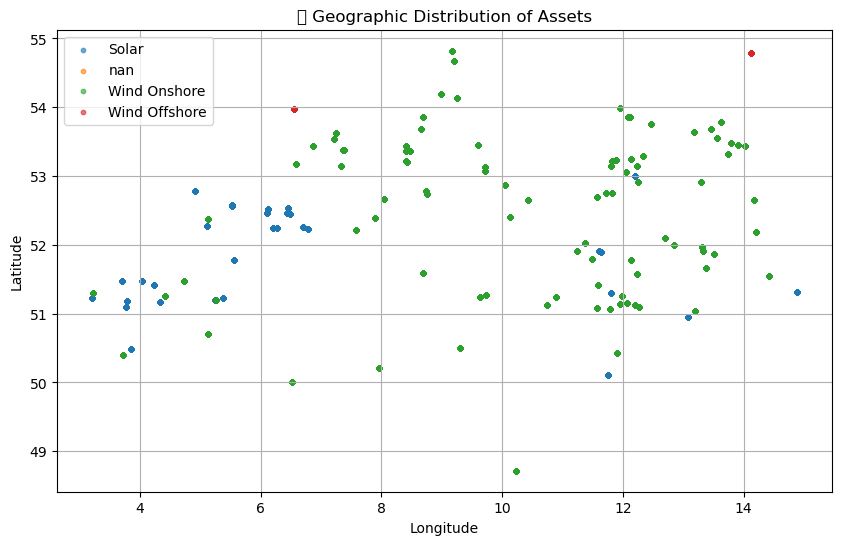

In [46]:
# Plot all sites by latitude and longitude
plt.figure(figsize=(10, 6))
for site_type in part1_df['type'].unique():
    subset = part1_df[part1_df['type'] == site_type]
    plt.scatter(subset['longitude'], subset['latitude'], label=site_type, alpha=0.6, s=10)

plt.title("🌍 Geographic Distribution of Assets")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Define the map center roughly at central Europe
map_center = [50.5, 8.0]  # Between Germany, BE, and NL
m = folium.Map(location=map_center, zoom_start=6, tiles='OpenStreetMap')

# Color mapping by type
color_map = {
    'Solar': 'orange',
    'Wind Onshore': 'blue',
    'Wind Offshore': 'green'
}

# Add asset locations with MarkerCluster
marker_cluster = MarkerCluster().add_to(m)

for _, row in sites_df.iterrows():
    tooltip = f"Site ID: {row['site']}<br>Type: {row['type']}<br>Capacity: {row['capacity']}"
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=5,
        color=color_map.get(row['type'], 'gray'),
        fill=True,
        fill_opacity=0.7,
        tooltip=tooltip
    ).add_to(marker_cluster)

# Display map
m

In [42]:
print("📆 Datetime coverage:")
print("Start:", part1_df['datetime'].min())
print("End  :", part1_df['datetime'].max())

# Count timestamps
print("\n🕒 Number of unique hourly timestamps:", part1_df['datetime'].nunique())

📆 Datetime coverage:
Start: 2018-12-31 23:00:00
End  : 2024-09-30 23:00:00

🕒 Number of unique hourly timestamps: 50401


In [43]:
# Completeness per site
site_completeness = part1_df.groupby('site_id')['datetime'].nunique().describe()
print("📊 Completeness per site (number of hourly records):")
display(site_completeness)

📊 Completeness per site (number of hourly records):


count      170.000000
mean     26739.788235
std      13345.126028
min       6553.000000
25%      15593.500000
50%      26291.500000
75%      35063.750000
max      50400.000000
Name: datetime, dtype: float64

In [51]:
# Group by country and type
site_counts = sites_df.groupby(['country', 'type'])['site'].nunique().reset_index()

# Rename for clarity
site_counts.rename(columns={'site': 'site_count'}, inplace=True)

# Preview
display(site_counts)


KeyError: 'country'